In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/KDT/과제/8_YOLO v1')
print(sys.version)

3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import torch
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import torchvision
import torch.nn as nn

from collections import defaultdict
from ipywidgets import interact
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision import models, transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from util import CLASS_NAME_TO_ID, visualize, visualize_bbox, save_model
from torchvision.ops import nms
from albumentations.pytorch import ToTensorV2

In [ ]:
!unzip '/content/drive/MyDrive/KDT/과제/8_YOLO v1/DataSet.zip'

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: train/a68858a316999d02.jpg  
  inflating: train/a68c64c8fc996e2f.jpg  
  inflating: train/a68e2c3746b43efe.jpg  
  inflating: train/a6919da5b27eab7c.jpg  
  inflating: train/a69229cf87bd0c1a.jpg  
  inflating: train/a6936ea349360dda.jpg  
  inflating: train/a69782378ab216fa.jpg  
  inflating: train/a69f6ee5964a59b1.jpg  
  inflating: train/a6a015f4dffec6ab.jpg  
  inflating: train/a6a7516de40fbc05.jpg  
  inflating: train/a6aa310bd8eea104.jpg  
  inflating: train/a6aadcf43f4ca464.jpg  
  inflating: train/a6b383c75e535cac.jpg  
  inflating: train/a6b4621118e8e034.jpg  
  inflating: train/a6c61a6228e7cbbc.jpg  
  inflating: train/a6cf70fe15323a12.jpg  
  inflating: train/a6d181b95bd96a0e.jpg  
  inflating: train/a6d26d8ed4ece82b.jpg  
  inflating: train/a6d51dffa95226cc.jpg  
  inflating: train/a6d5bb11b184b6db.jpg  
  inflating: train/a6d84a551ad7cddf.jpg  
  inflating: train/a6d878059d2cdf92.jpg  
  inflating: train/a6dcdf4f174ab675.jpg 

In [ ]:
data_dir = '/content'
data_dir_trian = '/content/train/'

data_df = pd.read_csv(os.path.join(data_dir, 'df.csv'))

data_df

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,0000599864fd15b3,xclick,Bus,1,0.343750,0.908750,0.156162,0.650047,1,0,...,0,0,0.421875,0.343750,0.795000,0.908750,0.156162,0.512700,0.650047,0.457197
1,00006bdb1eb5cd74,xclick,Truck,1,0.276667,0.697500,0.141604,0.437343,1,0,...,0,0,0.299167,0.276667,0.697500,0.659167,0.141604,0.241855,0.352130,0.437343
2,00006bdb1eb5cd74,xclick,Truck,1,0.702500,0.999167,0.204261,0.409774,1,1,...,0,0,0.849167,0.702500,0.906667,0.999167,0.204261,0.398496,0.409774,0.295739
3,00010bf498b64bab,xclick,Bus,1,0.156250,0.371250,0.269188,0.705228,0,0,...,0,0,0.274375,0.371250,0.311875,0.156250,0.269188,0.493882,0.705228,0.521691
4,00013f14dd4e168f,xclick,Bus,1,0.287500,0.999375,0.194184,0.999062,0,1,...,0,0,0.920000,0.999375,0.648750,0.287500,0.194184,0.303940,0.999062,0.523452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24057,fff2b15ad6007d0e,activemil,Truck,1,0.277344,0.622656,0.226389,0.859722,0,0,...,0,0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
24058,fff376d20410e4c9,xclick,Bus,1,0.295625,0.558750,0.306667,0.397500,1,0,...,1,0,0.424375,0.316250,0.295625,0.558750,0.306667,0.397500,0.382500,0.335833
24059,fff376d20410e4c9,xclick,Bus,1,0.348125,0.701250,0.423333,0.744167,0,0,...,1,0,0.478750,0.493125,0.348125,0.701250,0.423333,0.744167,0.537500,0.523333
24060,fffde5953a818927,xclick,Bus,1,0.277500,0.605625,0.565000,0.795833,0,0,...,0,0,0.488125,0.277500,0.517500,0.605625,0.565000,0.670000,0.795833,0.704167


In [ ]:
index = 3
image_files = [fn for fn in os.listdir(data_dir_trian) if fn.endswith('jpg')]
image_file = image_files[index]
image_file

'c81b8d807396c58e.jpg'

In [ ]:
image_path = os.path.join(data_dir_trian, image_file)
image_path

'/content/train/c81b8d807396c58e.jpg'

In [ ]:
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image.shape

(190, 256, 3)

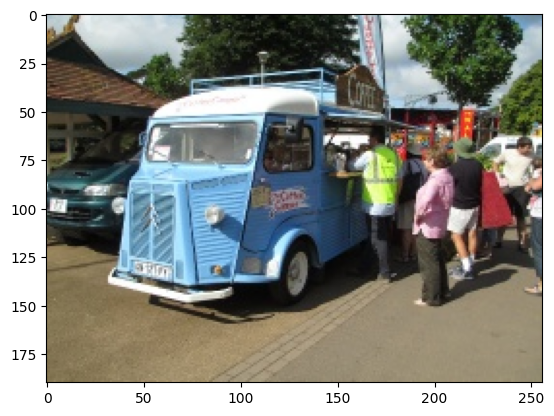

In [ ]:
plt.imshow(image)

In [ ]:
image_id = image_file.split('.')[0]
image_id

'c81b8d807396c58e'

In [ ]:
meta_data = data_df[data_df['ImageID'] == image_id]
meta_data

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
19225,c81b8d807396c58e,activemil,Truck,1,0.091875,0.709375,0.180896,0.819949,1,0,...,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [ ]:
cate_names = meta_data['LabelName'].values
cate_names

array(['Truck'], dtype=object)

In [ ]:
bboxes = meta_data[['XMin', 'XMax', 'YMin', 'YMax']].values
bboxes

array([[0.091875, 0.709375, 0.180896, 0.819949]])

In [ ]:
img_H, img_W, _ = image.shape
img_H, img_W

(190, 256)

In [ ]:
class_ids = [CLASS_NAME_TO_ID[cate_name] for cate_name in cate_names]
class_ids

[1]

In [ ]:
# 'XMin', 'XMax', 'YMin', 'YMax'
unnorm_bboxes = bboxes.copy()
# unnorm_bboxes

# X_Cen, Y_Cen, W, H
# XMax과 YMin의 자리를 바꾼다.
# 'XMin', YMin', 'XMax', 'YMax'
unnorm_bboxes[:, [1, 2]] = unnorm_bboxes[:, [2, 1]]

# 'XMax' 'YMax' -= 'XMin', 'YMin'
# 'XMax' - 'XMin', 'YMax' - 'YMin'
# 'XMin', 'YMin', W, H
unnorm_bboxes[:, 2:4] -= unnorm_bboxes[:,0:2]

# center 만들기
# XMin, YMin += (W, H / 2)
# 'XMin' + W/2 'YMin' + H/2
# X_cen, Y_cen, W, H
unnorm_bboxes[:, 0:2] += (unnorm_bboxes[:, 2:4] / 2)

unnorm_bboxes

array([[0.400625 , 0.5004225, 0.6175   , 0.639053 ]])

In [ ]:
unnorm_bboxes[:, [0, 2]] *= img_W
unnorm_bboxes[:, [1, 3]] *= img_H
unnorm_bboxes

array([[102.56    ,  95.080275, 158.08    , 121.42007 ]])

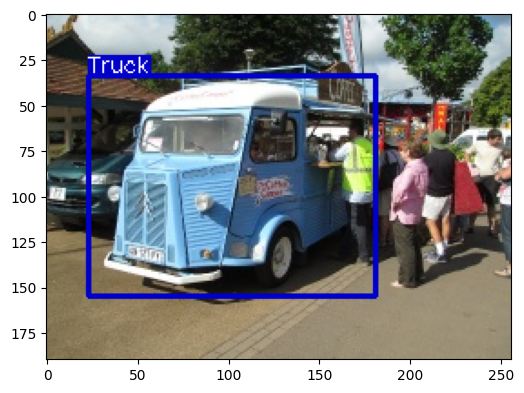

In [ ]:
canvas = visualize(image, unnorm_bboxes, class_ids)
plt.figure(figsize = (6, 6))
plt.imshow(canvas)
plt.show()

In [ ]:
@interact(index = (0, len(image_files)-1))
def show_sample(index = 0):
    image_file = image_files[index]
    image_path = os.path.join('/content/train/', image_file)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    image_id = image_file.split('.')[0]
    meta_data = data_df[data_df['ImageID'] == image_id]
    cate_names = meta_data['LabelName'].values
    bboxes = meta_data[['XMin', 'XMax', 'YMin', 'YMax']].values
    img_H, img_W, _ = image.shape
    class_ids = [CLASS_NAME_TO_ID[cate_name] for cate_name in cate_names]

    unnorm_bboxes = bboxes.copy()
    unnorm_bboxes[:, [1, 2]] = unnorm_bboxes[:, [2, 1]]
    unnorm_bboxes[:, 2:4] -= unnorm_bboxes[:,0:2]
    unnorm_bboxes[:, 0:2] += (unnorm_bboxes[:, 2:4] / 2)

    unnorm_bboxes[:, [0, 2]] *= img_W
    unnorm_bboxes[:, [1, 3]] *= img_H

    canvas = visualize(image, unnorm_bboxes, class_ids)
    plt.figure(figsize = (6, 6))
    plt.imshow(canvas)
    plt.show()

interactive(children=(IntSlider(value=0, description='index', max=13702), Output()), _dom_classes=('widget-int…

In [ ]:
class Detection_dataset():
    def __init__(self, data_dir, phase, transformer=None):
        self.data_dir = data_dir
        self.phase = phase
        self.data_df = pd.read_csv(os.path.join(self.data_dir, 'df.csv'))
        self.image_files = [fn for fn in os.listdir(os.path.join(self.data_dir, phase)) if fn.endswith('jpg')]
        self.transformer = transformer

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        filename, image = self.get_image(index)
        bboxes, class_ids = self.get_label(filename)
        if self.transformer:
            transformed_data = self.transformer(image = image, bboxes = bboxes, class_ids = class_ids)
            image = transformed_data['image']
            bboxes = np.array(transformed_data['bboxes'])
            class_ids = np.array(transformed_data['class_ids'])

        target = np.concatenate((bboxes, class_ids[:, np.newaxis]), axis = 1)

        return image, target, filename

    def get_image(self, index):
        filename = self.image_files[index]
        image_path = os.path.join(self.data_dir, self.phase, filename)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        return filename, image

    def get_label(self, filename):
        image_id = filename.split('.')[0]
        meta_data = data_df[data_df['ImageID'] == image_id]
        cate_names = meta_data['LabelName'].values
        class_ids = np.array([CLASS_NAME_TO_ID[cate_name] for cate_name in cate_names])

        bboxes = meta_data[['XMin', 'XMax', 'YMin', 'YMax']].values
        bboxes[:, [1, 2]] = bboxes[:, [2, 1]]
        bboxes[:, 2:4] -= bboxes[:, 0:2]
        bboxes[:, 0:2] += (bboxes[:, 2:4] / 2)

        return bboxes, class_ids

In [ ]:
dataset = Detection_dataset(data_dir = data_dir, phase = 'train', transformer = None)
dataset[3]

(array([[[182, 190, 203],
         [177, 190, 199],
         [175, 199, 201],
         ...,
         [114, 136, 160],
         [112, 133, 152],
         [113, 134, 151]],
 
        [[180, 190, 202],
         [178, 192, 201],
         [173, 194, 199],
         ...,
         [113, 137, 161],
         [113, 138, 158],
         [116, 142, 159]],
 
        [[178, 195, 203],
         [176, 193, 201],
         [176, 195, 202],
         ...,
         [115, 146, 167],
         [115, 146, 167],
         [117, 148, 169]],
 
        ...,
 
        [[118, 104,  69],
         [128, 114,  79],
         [123, 109,  74],
         ...,
         [148, 141, 113],
         [147, 140, 112],
         [145, 138, 110]],
 
        [[122, 108,  73],
         [130, 116,  81],
         [127, 113,  78],
         ...,
         [148, 141, 113],
         [147, 140, 111],
         [146, 139, 110]],
 
        [[126, 112,  77],
         [133, 119,  84],
         [134, 120,  85],
         ...,
         [147, 140, 112],
  

In [ ]:
index = 3
image, target, filename = dataset[index]

In [ ]:
target[0], filename

(array([102.56    ,  95.080275, 158.08    , 121.42007 ,   1.      ]),
 'c81b8d807396c58e.jpg')

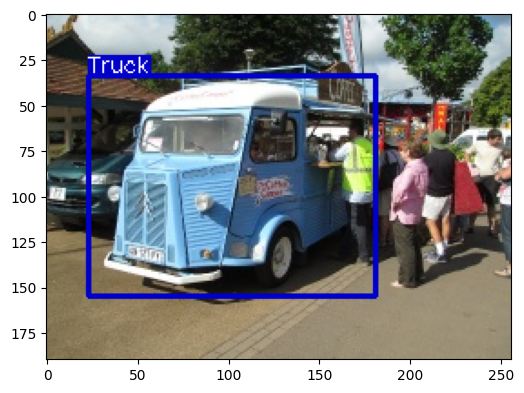

In [ ]:
bboxes = target[:, 0:4]
class_ids = target[:, 4]

img_H, img_W, _ = image.shape
bboxes[:, [0, 2]] *= img_W
bboxes[:, [1, 3]] *= img_H

canvas = visualize(image, bboxes, class_ids)

plt.figure(figsize=(6, 6))
plt.imshow(canvas)
plt.show()

In [ ]:
@interact(index = (0, len(image_files)-1))
def show_sample(index = 0):
    image, target, filename = dataset[index]

    bboxes = target[:, 0:4]
    class_ids = target[:, 4]

    img_H, img_W, _ = image.shape
    bboxes[:, [0, 2]] *= img_W
    bboxes[:, [1, 3]] *= img_H

    canvas = visualize(image, bboxes, class_ids)

    plt.figure(figsize=(6, 6))
    plt.imshow(canvas)
    plt.show()

interactive(children=(IntSlider(value=0, description='index', max=13702), Output()), _dom_classes=('widget-int…

### Albumentations

* 이미지 데이터 증강 모듈
* 다양한 증강 기법 : 회전, 이동, 크기 조정, 반전, 색상 변환
* 빠른 성능
* API를 제공
* [ALBUMENTATIONS](https://albumentations.ai/)

In [ ]:
IMAGE_SIZE = 448

transformer = A.Compose([
    A.Resize(height = IMAGE_SIZE, width = IMAGE_SIZE),
    A.Normalize(mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225)),
    ToTensorV2(),
    ],
    bbox_params = A.BboxParams(format='yolo', label_fields=['class_ids'])
)

In [ ]:
transformed_dataset = Detection_dataset(data_dir = data_dir, phase = 'train', transformer = transformer)
dataset[1]

In [ ]:
@interact(index=(0, len(transformed_dataset) - 1))
def show_sample(index=0):
    image, target, filename = transformed_dataset[index]
    bboxes = target[:, 0:4]
    class_ids = target[:, 4]
    __, img_H, img_W,  = image.shape
    bboxes[:, [0, 2]] *= img_W
    bboxes[:, [1, 3]] *= img_H
    np_image = make_grid(image, normalize=True).cpu().permute(1, 2, 0).numpy()
    canvas = visualize(np_image, bboxes, class_ids)
    plt.figure(figsize=(6, 6))
    plt.imshow(canvas)
    plt.axis('on')
    plt.show()

In [ ]:
# collate : 데이터로더에 들어가는 파라미터 중 하나
# 콜백함수, 데이터를 불러오기 전에 미리 처리해야 할 것들은 처리하여 dataloader로 만듬

def collate_fn(batch):
    image_list = []
    target_list = []
    filename_list = []

    for img, target, filename in batch:
        image_list.append(img)
        target_list.append(target)
        filename_list.append(filename)

    return torch.stack(image_list, dim = 0), target_list, filename_list

In [ ]:
BATCH_SIZE = 64

trainset = Detection_dataset(data_dir = data_dir, phase = 'train', transformer = transformer)
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True, collate_fn = collate_fn)

In [ ]:
for index, batch in enumerate(trainloader):
    images = batch[0]
    target = batch[1]
    filenames = batch[2]
    if index == 0:
        break
print(target, filenames)

In [ ]:
def build_dataloader(data_dir, batch_size = 64, image_size = 448):
    transformer = A.Compose([
        A.Resize(height = image_size, width = image_size),
        A.Normalize(mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225)),
        ToTensorV2()
    ],
    bbox_params = A.BboxParams(format='yolo', label_fields=['class_ids'])
    )

    dataloaders = {}

    traindataset = Detection_dataset(data_dir = data_dir, phase = 'train', transformer = transformer)
    dataloaders['train'] = DataLoader(traindataset, batch_size = batch_size, shuffle = True, collate_fn = collate_fn)

    valdataset = Detection_dataset(data_dir = data_dir, phase = 'val', transformer = transformer)
    dataloaders['val'] = DataLoader(valdataset, batch_size = 1, shuffle = False, collate_fn = collate_fn)

    return dataloaders

In [ ]:
BATCH_SIZE = 64
dloaders = build_dataloader(data_dir, batch_size=BATCH_SIZE)

In [ ]:
for phase in ['train', 'val']:
    for index, batch in enumerate(dloaders[phase]):
        images = batch[0]
        targets = batch[1]
        filenames = batch[2]
        print(targets)
        if index == 0:
            break

In [ ]:
resnet18 = torchvision.models.resnet18(pretrained = True)
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
layers = [m for m in resnet18.children()]
layers

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

In [ ]:
testnet = nn.Sequential(*layers[:-2])
testnet

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [ ]:
import torch
import torch.nn as nn

class YOLOv1Loss(nn.Module):
    def __init__(self, num_classes, S=7, B=2):
        super(YOLOv1Loss, self).__init__()
        self.num_classes = num_classes
        self.S = S  # Grid 사이즈
        self.B = B  # Bounding Box 개수

        # 예시로 사용한 hyperparameters
        self.lambda_coord = 5.0
        self.lambda_noobj = 0.5

        self.mse_loss = nn.MSELoss()
        self.bce_loss = nn.BCEWithLogitsLoss()

    def forward(self, predictions, targets):
        """
        predictions: 모델의 출력. (batch_size, S, S, (B * 5) + num_classes)
        targets: 실제 타겟. (batch_size, S, S, (B * 5) + num_classes)
        """
        # 타겟의 차원 중 Bounding Box 정보와 클래스 정보를 나눠서 추출
        target_bbox = targets[..., :self.B * 5]
        target_class = targets[..., self.B * 5:]

        # 모델의 출력도 동일하게 처리
        pred_bbox = predictions[..., :self.B * 5]
        pred_class = predictions[..., self.B * 5:]

        # Bounding Box 정보에서 confidence와 클래스 정보를 분리
        target_conf = target_bbox[..., 4::5]
        target_xy = target_bbox[..., :2]
        target_wh = target_bbox[..., 2:4]

        pred_conf = pred_bbox[..., 4::5]
        pred_xy = pred_bbox[..., :2]
        pred_wh = pred_bbox[..., 2:4]

        # Confidence loss 계산
        loss_conf = self.bce_loss(pred_conf, target_conf)

        # Objectness loss 계산 (실제 객체가 있는 Bounding Box에 대해서만 계산)
        object_mask = target_conf > 0
        loss_obj = self.mse_loss(pred_xy[object_mask], target_xy[object_mask]) + \
                   self.mse_loss(pred_wh[object_mask], target_wh[object_mask])

        # No-objectness loss 계산 (실제 객체가 없는 Bounding Box에 대해서만 계산)
        no_object_mask = target_conf == 0
        loss_noobj = self.lambda_noobj * self.bce_loss(pred_conf[no_object_mask], target_conf[no_object_mask])

        # Class loss 계산
        loss_class = self.bce_loss(pred_class, target_class)

        # 전체 손실 계산
        total_loss = loss_conf + loss_obj + loss_noobj + loss_class

        return total_loss


In [ ]:
import torch
import torchvision
import torch.nn as nn

# ResNet-18 불러오기
resnet18 = torchvision.models.resnet18(pretrained=True)

# ResNet-18의 기본 모델 아키텍처 레이어들을 추출하여 backbone 정의
backbone_layers = list(resnet18.children())[:-2]
backbone = nn.Sequential(*backbone_layers)

# YOLO v1 모델 정의 (여기서는 예시로 간단하게 정의)
class YOLOv1(nn.Module):
    def __init__(self, num_classes, backbone):
        super(YOLOv1, self).__init__()
        self.num_classes = num_classes
        self.backbone = backbone
        # YOLO v1의 추가적인 레이어들을 여기에 정의할 수 있습니다.
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        # LAYER 2
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(192, momentum=0.01),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        # LAYER 3
        self.layer3 = nn.Sequential(
            nn.Conv2d(192, 128, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(128, momentum=0.01),
            nn.LeakyReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256, momentum=0.01),
            nn.LeakyReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=1, stride=1, padding=1),
            nn.BatchNorm2d(256, momentum=0.01),
            nn.LeakyReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(512, momentum=0.01),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        # LAYER 4
        self.layer7 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(256, momentum=0.01),
            nn.LeakyReLU())
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512, momentum=0.01),
            nn.LeakyReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(256, momentum=0.01),
            nn.LeakyReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512, momentum=0.01),
            nn.LeakyReLU())
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(256, momentum=0.01),
            nn.LeakyReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512, momentum=0.01),
            nn.LeakyReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(256, momentum=0.01),
            nn.LeakyReLU())
        self.layer14 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512, momentum=0.01),
            nn.LeakyReLU())
        self.layer15 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(512, momentum=0.01),
            nn.LeakyReLU())
        self.layer16 = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024, momentum=0.01),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        # LAYER 5
        self.layer17 = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(512, momentum=0.01),
            nn.LeakyReLU())
        self.layer18 = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024, momentum=0.01),
            nn.LeakyReLU())
        self.layer19 = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(512, momentum=0.01),
            nn.LeakyReLU())
        self.layer20 = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024, momentum=0.01),
            nn.LeakyReLU())
        self.layer21 = nn.Sequential(
            nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024, momentum=0.01),
            nn.LeakyReLU())
        self.layer22 = nn.Sequential(
            nn.Conv2d(1024, 1024, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(1024, momentum=0.01),
            nn.LeakyReLU())
        # LAYER 6
        self.layer23 = nn.Sequential(
            nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024, momentum=0.01),
            nn.LeakyReLU())
        self.layer24 = nn.Sequential(
            nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024, momentum=0.01),
            nn.LeakyReLU())
        self.fc1 = nn.Sequential(
            nn.Linear(7 * 7 * 1024, 4096),
            nn.LeakyReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(4096, 7 * 7 * ((5) + self.num_classes))
        )

    def forward(self, x):
        # Backbone 통과
        features = self.backbone(x)

        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = self.layer14(out)
        out = self.layer15(out)
        out = self.layer16(out)
        out = self.layer17(out)
        out = self.layer18(out)
        out = self.layer19(out)
        out = self.layer20(out)
        out = self.layer21(out)
        out = self.layer22(out)
        out = self.layer23(out)
        out = self.layer24(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = out.reshape((-1, 7, 7, ((5) + self.num_classes)))
        out[:, :, :, 0] = torch.sigmoid(out[:, :, :, 0])  # sigmoid to objness1_output
        out[:, :, :, 5:] = torch.sigmoid(out[:, :, :, 5:])  # sigmoid to class_output
        return out



In [ ]:
# YOLO v1 모델 생성
num_classes = 2  # 예시로 클래스 수를 2로 가정
yolo_model = YOLOv1(num_classes, backbone)

# YOLO 모델을 원하는 데이터셋에 맞게 파인튜닝(fine-tuning)하고 학습하는 코드를 추가하면 됩니다.
# 예시: 데이터 로딩, 손실 함수 정의, 옵티마이저 설정 등

In [ ]:
yolo_model

YOLOv1(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [ ]:
# 학습코드
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 2  # 예시 데이터셋 클래스 수

model = YOLOv1(num_classes, backbone)  # YOLO 모델 생성
model.to(device)

criterion = YOLOv1Loss(num_classes)  # Loss 함수 생성
optimizer = optim.Adam(model.parameters(), lr=0.001)  # 옵티마이저 생성

# 학습 루프
num_epochs = 10  # 예시로 10 에폭 설정

for epoch in range(num_epochs):
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0

        for batch_idx, batch in enumerate(dloaders[phase]):
          images = batch[0][0].to(device)  # Already a PyTorch tensor
          if len(images.shape) == 3:
            images = images.unsqueeze(0)  # Add batch dimension

          targets = torch.from_numpy(batch[1][0]).to(device)


          optimizer.zero_grad()

        with torch.set_grad_enabled(phase == 'train'):
            outputs = model(images)
            loss = criterion(outputs, targets)

            if phase == 'train':
                loss.backward()
                optimizer.step()

        running_loss += loss.item() * images.size(0)
        epoch_loss = running_loss / len(dloaders[phase].dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}] - {phase.capitalize()} Loss: {epoch_loss:.4f}")

print("Training Finished")

ValueError: ignored